### Exercice 1 ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
from sklearn.metrics import mean_squared_error

Question 1 :

Pour générer une variable aléatoire $X$, suivant la loi définie par les $(p_i)_{i \in [\![ 1,n ]\!]}$ tels que:
$$
\forall i \in [\![ 1,n ]\!], \mathbb{P}(X=x_i)=p_i
$$
on utilise une variable aléatoire $U$ suivant la loi uniforme $\mathcal{U}([0,1])$. 


On pose $p_0=0$, puis on cherche $i \in [\![ 1,n ]\!]$ tel que $U \in [\sum_{k=0}^{i-1} p_k, \sum_{k=0}^{i} p_k ] $. On retourne le $x_i$ correspondant. 

Question 2

In [2]:
def generate_random_X(states, probas):
  p = np.random.uniform(0,1)
  cand = 0
  s = probas[cand]
  while (cand< len(probas)) & (p > s):
    cand +=1
    s+= probas[cand]
  if cand > len(probas):
    print("Erreur : somme des probas inf à 1")
  return states[cand]

Question 3

In [3]:
def generate_sequence(N, states, probas):
  list_X = []
  for i in range(N):
    list_X.append(generate_random_X(states, probas))
  return list_X

[]

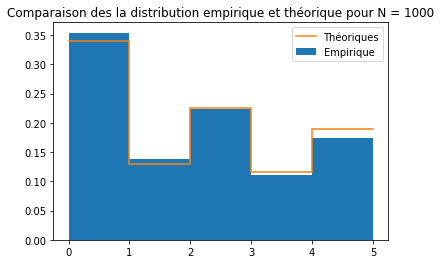

In [4]:
#Generate the distribution of X

nb_states = 5
states = range(nb_states)

# générer probas pour que somme des p_i = 1 et p_i >0
probas = np.random.random(nb_states)
probas = probas / probas.sum()

N = 1000
list_X = generate_sequence(N, states, probas)

plt.hist(list_X, range(0,nb_states+1),  density = True, label = "Empirique")
plt.step( range(0,nb_states+1), [probas[0]]+ list(probas), label = "Théoriques")
plt.legend()
plt.title("Comparaison des la distribution empirique et théorique pour N = "+str(N))
plt.plot()

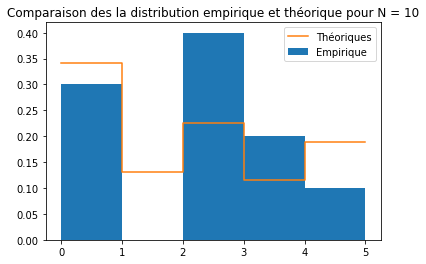

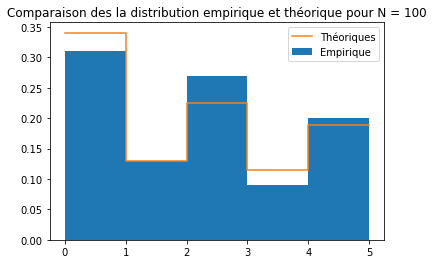

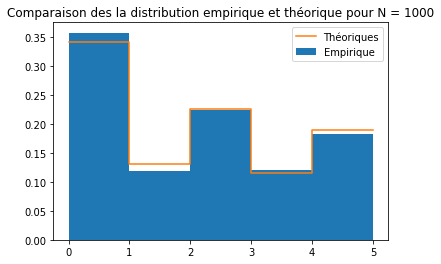

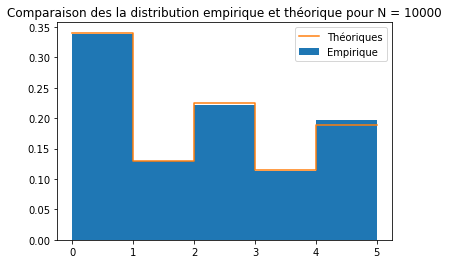

In [5]:
for n in [10,100,1000,10000]:
  list_X = generate_sequence(n, states, probas)
  plt.hist(list_X, range(0,nb_states+1),  density = True, label = "Empirique")
  plt.step( range(0,nb_states+1), [probas[0]]+ list(probas), label = "Théoriques")
  plt.legend()
  plt.title("Comparaison des la distribution empirique et théorique pour N = "+str(n))
  plt.plot()
  plt.show()

Plus N augmente, plus la distribution empirique se rapproche de la distribution théorique.

### Exercice 2 ###

Question 1

On cherche à calculer la vraissemblance $\mathcal{L}$ de $\theta$ à partir de la sortie $(x_i)_{i \in [\![ 1,n ]\!]}$ de l'échantillon $(X_i)_{i \in [\![ 1,n ]\!]}$ i.i.d défini dans l'énoncé. 


Pour chaque $i \in [\![ 1,n ]\!]$, on a:
\begin{aligned}
f_{\theta}(x_i)  &= \mathbb{E}_{Z_i} [f_{\theta}(x_i| z_i)]\\
& = \sum_{j= 1}^{m} \alpha_j f_{\theta}(x_i| z_i = j )
\end{aligned}

On note $\phi(x|\mu, \Sigma)$ la densité de la gaussienne $\mathcal{N}(\mu,\sigma) $ tel que $ \forall x \in \mathbb{R}^N, \phi(x|\mu, \Sigma) =\frac{1}{\sqrt{(2 \pi)^N |\Sigma |}} \exp( - \frac{1}{2} (x-\mu)^T  \Sigma^{-1} (x-\mu))$ avec $N$ étant la dimension de la gaussienne (dimension de $x$). On a donc : 
\begin{aligned}
f_{\theta}(x_i)  
& = \sum_{j= 1}^{m} \alpha_j \phi(x_i|\mu_j, \Sigma_j)
\end{aligned}
Par idépendance des $X_i$, on a:
\begin{aligned}
\mathcal{L}(x_1,...,x_n;\theta) =  &= \prod_{i=1}^{n} f_{\theta}(x_i) \\
 &= \prod_{i=1}^{n} \sum_{j= 1}^{m} \alpha_j \phi(x_i|\mu_j, \Sigma_j)
\end{aligned}

Et le paramètre $\theta$ est égale à $(\alpha_1,...,\alpha_m,\mu_1,...,\mu_m,\Sigma_1,...,\Sigma_n)$. 

Question 2

/usr/local/lib/python3.7/dist-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


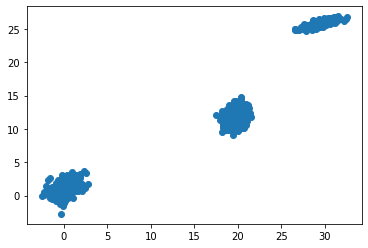

In [6]:
#Initialisation des paramètres aléatoirement
n = 1000

m = 3
states = range(m)
alpha = np.ones(m)/m


Z = generate_sequence(n, states, alpha)

mu = np.zeros((m,2))
for j in range(m):
  mu[j,:] = np.random.uniform(low = j*10, high = (j+1)*10,size = (2)) ## initialize mu to have 3 distinct groups when plot

sigma = np.random.uniform(low = 0, high = 1,size = (m,2,2))


X = [st.multivariate_normal.rvs(size=1,mean=mu[int(z)],cov=sigma[int(z)]) for z in Z]
X = np.array(X)

plt.scatter(X[:,0],X[:,1])

Question 3

$\textbf{Théorie:}$

On cherche à maximiser la vraissemblance, ie on cherche $\theta^*$ tel que $\theta^* \in arg \max_{\theta} \mathcal{L}(x_1,...,x_n;\theta)$ ce qui revient à trouver $\theta^* \in arg \max_{\theta} log(\mathcal{L}(x_1,...,x_n;\theta))$. Pour cela on utilise l'algorithme d'espérance-maximisation (EM) afin de trouver une estimation de $\theta^*$. L'algorithme s'effectue en 2 étapes : à l'itération t, on calcule de l'espérance $B(\theta,\theta_t) = \mathbb{E} _{Z \sim q_{\theta_t}(.|X)} \left[log\left(q_{\theta} (Z, (x_i)_1^n)\right)\right]$ (étape E) (avec q la densité) et on calcule $\theta_{t+1} = arg \max_{\theta} B(\theta,\theta_t)$ (étape M).

\\

$\rightarrow$ Étape E : Calcul de $B(\theta,\theta_t)$:

\begin{aligned}
B(\theta,\theta_t) &=  \mathbb{E} _{Z\sim q_{\theta_t}(.|X)} \left[\prod_{i=1}^{n}log\left(q_{\theta} (z_i, x_i)\right)\right] \\
&= \sum_{i=1}^{n} \mathbb{E} _{Z_i\sim q_{\theta_t}(.|X_i)} \left[log\left(q_{\theta} (z_i, x_i)\right)\right]\\
&= \sum_{i=1}^{n} \sum_{j=1}^{m} \mathbb{P}(Zi= j|X_i,\theta_t) log\left(q_{\theta} (z_i=j, x_i)\right)
\end{aligned}

Or, 
\begin{aligned}
log\left(q_{\theta} (z_i=j, x_i)\right) &= log\left(q_{\theta} ( x_i|z_i=j)q_{\theta} (z_i=j)\right)\\
&= log\left(\phi(x_i|\mu_j,\Sigma_j)\alpha_j   \right)\\
&= log(\alpha_j ) − \frac{N}{2} log(2\pi) − \frac{1}{2} log(|\Sigma_j|)−  \frac{1}{2}(x_i-\mu_j)^T  \Sigma_j^{-1} (x_i-\mu_j)
\end{aligned}


Et par formules de Bayes, on a: 
\begin{aligned}
\mathbb{P}(Zi= j|X_i,\theta_t)&= q_{\theta_t} (z_i=j|x_i) \\
&= \frac{q_{\theta_t} (x_i|z_i=j) q_{\theta_t} (z_i=j) }{q_{\theta_t} (x_i)}\\
&= \frac{ \phi(x_i|\mu_j^t,\Sigma_j^t)\alpha_j^t }{q_{\theta_t} (x_i)}\\
&= p_{ij}^t
\end{aligned}

Donc, 
\begin{aligned}
B(\theta,\theta_t) &=  \sum_{i=1}^{n} \sum_{j=1}^{m}  p_{ij}^t \left(log(\alpha_j ) − \frac{N}{2} log(2\pi) − \frac{1}{2} log(|\Sigma_j|)−  \frac{1}{2}(x_i-\mu_j)^T  \Sigma_j^{-1} (x_i-\mu_j) \right)
\end{aligned}

\\

$\rightarrow$ Étape M : Calcul de $\theta_{t+1} = arg \max_{\theta} B(\theta,\theta_t)$, ie on cherche  $(\alpha^{t+1},\mu^{t+1},\Sigma^{t+1})$ :
Pour résoudre ce problème, regarde la dérivée partielle de $B(\theta,\theta_t)$ par rapport à $(\alpha^t,\mu^t,\Sigma^t)$ de $\theta_t$. 

\\
$\bullet$ Calcul de $\alpha^{t+1}$
On introduit un multiplicateur de Lagrange pour gérer la première contrainte $\sum_{j=1}^{m} \alpha_j =1$ :
\begin{aligned}
G(\theta,\theta_t;\lambda) = B(\theta,\theta_t) + \lambda \left( 1 -\sum_{j=1}^{m} \alpha_j \right)
\end{aligned}
On cherche maintenant à maximiser $\max_{\theta,\lambda} G(\theta,\theta_t;\lambda) $. La dérivée partielle selon $\lambda$ nous redonne la contrainte. On regarde la dérivée selon $\alpha_j \forall j \in [\![ 1,m ]\!]$ : 
\begin{aligned}
\frac{\partial{G(\theta,\theta_t;\lambda)}}{{\partial \alpha_j}} 
&= \sum_{i=1}^n p_{ij}^t\frac{1}{\alpha_j} - \lambda = 0 
\end{aligned}

$\Rightarrow $ $$ \alpha_j = \frac{\sum_{i=1}^n p_{ij}^t}{\lambda } $$
Or: 
\begin{aligned}
\sum_{j=1}^{m} \alpha_j& = 1\\
&=\frac{\sum_{i=1}^n \sum_{j=1}^{m} p_{ij}^t}{\lambda }  \\
& = \frac{n}{\lambda }  
\end{aligned}


Donc, on a $\fbox{$\forall j \in [\![ 1,m ]\!]$, $\alpha^{t+1}_j = \frac{1}{n} \sum_{i=1}^n p_{ij}^t$}$.

\\
$\bullet$ Calcul de $\mu^{t+1}$
\begin{aligned}
\nabla_{\mu_j} B(\theta,\theta_t) & = \nabla_{\mu_j}  \left[ \sum_{i=1}^{n}  p_{ij}^t \left(−  \frac{1}{2}(x_i-\mu_j)^T  \Sigma_j^{-1} (x_i-\mu_j)\right)\right]\\
&= \sum_{i=1}^{n}  p_{ij}^t (x_i-\mu_j)\\
&= 0
\end{aligned}


D'où,  $\fbox{$ \forall j \in [\![ 1,m ]\!]$ : $\mu^{t+1}_j = \frac{\sum_{i=1}^{n}  p_{ij}^t x_i}{\sum_{i=1}^{n}  p_{ij}^t }$}$

\\
$\bullet$ Calcul de $\Sigma^{t+1}$ : 
Comme on a $\Sigma_j^{-1}$ dans l'expression de $B(\theta,\theta_t)$ et $|\Sigma_j|=det(\Sigma_j) = det(\Sigma_j^{-1})^{-1}=  |\Lambda_j|^{-1}$ que , on pose une nouvelle variable $\Lambda_j = \Sigma_j^{-1}$. On dérive $B(\theta,\theta_t)$ par rapport à cette nouvelle variable:

\begin{aligned}
\nabla_{\Lambda_j} B(\theta,\theta_t) 
&=\nabla_{\Lambda_j}  \left[ \sum_{i=1}^{n}  p_{ij}^t \left(\frac{1}{2} log(|\Lambda_j|)−  \frac{1}{2}(x_i-\mu_j)^T  \Lambda_j(x_i-\mu_j) \right)\right]\\
&= \frac{1}{2} \sum_{i=1}^{n}  p_{ij}^t  \left( (\Lambda_j^{-1})^T -(x_i-\mu_j)(x_i-\mu_j)^T \right)\\
&= 0
\end{aligned}

Comme $\Sigma_j$ est symétrique (matrice de covariance) alors : $$\fbox{$ \forall j \in [\![ 1,m ]\!] :  \Sigma_j^{t+1} = \frac{\sum_{i=1}^{n}  p_{ij}^t (x_i-\mu_j)(x_i-\mu_j)^T}{\sum_{i=1}^{n}  p_{ij}^t}$}$$

$\textbf{Algorithme de l'EM :}$



In [7]:
def EM(X, N_max, alpha_0, mu_0, sigma_0):
  (n,_) = X.shape
  m = alpha_0.shape[0]

  alpha_t = alpha_0
  mu_t = mu_0
  sigma_t = sigma_0

  log_L = []
  p_t = np.zeros((n,m))

  for i_iter in range(1,N_max+1):
    if i_iter% 100 == 0:
      print('iter n°',i_iter)

    ### Étape E :
    # Calcul de p_t
    p_t = np.array([ st.multivariate_normal.pdf(X,mean = mu_t[j], cov = sigma_t[j],allow_singular=True)*alpha_t[j] for j in range(m)]).T
    for i in range(n):
      p_t[i,:] = p_t[i,:] / p_t[i,:].sum()
      
    ### Étape M :
    # Calcul des paramètres alpha_t, mu_t, sigma_t
    ## alpha_t
    alpha_t = (1/n)*p_t.sum(axis=0)

    for j in range(m):
    ## mu_t
      mu_t[j] = p_t[:,j].dot(X)/(n*alpha_t[j])

    ## sigma_t
      temp = np.array([p_t[i,j]*((np.asmatrix(X[i] - mu_t[j]).T)@np.asmatrix(X[i] - mu_t[j])) for i in range(n)])
      sigma_t[j] = temp.sum(axis=0)/p_t[:,j].sum()

    #Calcul du log likehood
    log_L_t = np.array([ st.multivariate_normal.pdf(X,mean = mu_t[j], cov = sigma_t[j], allow_singular=True)*alpha_t[j] for j in range(m)]).T
    log_L.append(np.sum(np.log(log_L_t .sum(axis=1))))

  return log_L, alpha_t, mu_t, sigma_t

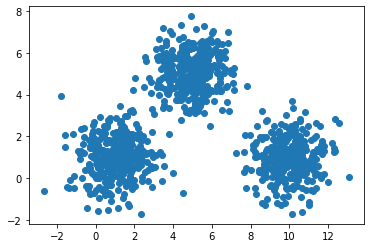

In [8]:
# Generation de X gaussian mixture avec X semi def positive
m = 3

mu = np.array([[1,1],[5,5],[10,1]])
sigma = np.array([np.eye(2) for i in range(m)]) 
X = [st.multivariate_normal.rvs(size=1,mean=mu[int(z)],cov=sigma[int(z)]) for z in Z]
X = np.array(X)

plt.scatter(X[:,0],X[:,1])

In [9]:
#Initialisation des paramètres

alpha_0 = np.ones(m)/m

mu_0 = X[np.random.randint(0,n,m)]
sigma_0 = np.array([np.eye(2) for i in range(m)]) 

N_max = 120

log_L, alpha_t, mu_t, sigma_t = EM(X, N_max, alpha_0, mu_0, sigma_0)

iter n° 100


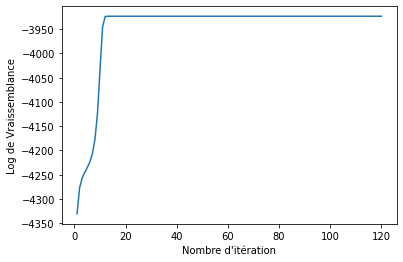

In [10]:
# Affichage des résultats

plt.plot(range(1,N_max+1),log_L)

plt.xlabel("Nombre d'itération")
plt.ylabel("Log de Vraissemblance")

plt.show()

On remarque que l'algorithme converge au bout d'une vingtaine d'itérations, on peut donc utiliser N_max = 30 pour réduire le temps de calcul.

Question 4

Text(0.5, 1.0, 'Estimation des paramètres pour le modèle de mélange gaussien')

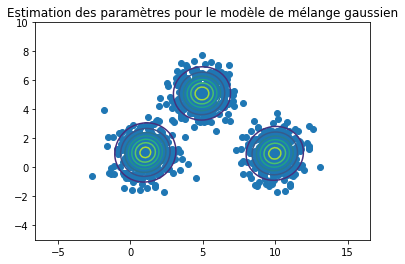

In [11]:
x = np.linspace(-5, 15, num=100)
y = np.linspace(-5, 10, num=100)
X_plot, Y_plot = np.meshgrid(x,y)

p = np.empty(X_plot.shape + (2,))
p[:, :, 0] = X_plot
p[:, :, 1] = Y_plot

for j in range(m):
    temp = st.multivariate_normal.pdf(p, mean = mu_t[j], cov = sigma_t[j])
    plt.contour(X_plot, Y_plot, temp)

plt.scatter(X[:,0],X[:,1])
plt.axis("equal")

plt.title("Estimation des paramètres pour le modèle de mélange gaussien")

In [12]:
print('\n### Comparaison des valeurs estimées aux vrais valeurs ###')
print('Vrai alpha : ', alpha)
print('Alpha estimé : ', alpha_t)
print('\n')
print('Vrai mu : \n', mu)
print('mu estimé: \n', mu_t)
print('\n')
print('Vrai sigma :\n', sigma)
print('Sigma estimé : \n', sigma_t)



### Comparaison des valeurs estimées aux vrais valeurs ###
Vrai alpha :  [0.33333333 0.33333333 0.33333333]
Alpha estimé :  [0.34647319 0.31302414 0.34050267]


Vrai mu : 
 [[ 1  1]
 [ 5  5]
 [10  1]]
mu estimé: 
 [[4.94806948 5.09730698]
 [9.96870714 0.96143029]
 [1.04016923 1.0269033 ]]


Vrai sigma :
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Sigma estimé : 
 [[[1.01306363 0.02028345]
  [0.02028345 0.88496534]]

 [[1.03085445 0.04070568]
  [0.04070568 0.91675575]]

 [[1.09790035 0.05360657]
  [0.05360657 1.0334754 ]]]


In [15]:
# on remarque qu'il y a une permuation dans les lignes des paramètres estimées par rapport aux vrais variables 
perm = [1,2,0]

alpha_t_perm = np.copy(alpha_t)
alpha_t_perm[perm ] = alpha_t_perm[[0,1,2]]
print('MSE pour alpha : ', mean_squared_error(alpha,alpha_t_perm))

mu_t_perm = np.copy(mu_t)
mu_t_perm[perm ] = mu_t_perm[[0,1,2]]
print('MSE pour mu : ', mean_squared_error(mu,mu_t_perm))

sigma_t_perm = np.copy(sigma_t)
sigma_t_perm[perm ] = sigma_t_perm[[0,1,2]]
print('MSE pour Sigma :',  mean_squared_error(sigma.transpose(2,0,1).reshape(3,-1), sigma_t_perm.transpose(2,0,1).reshape(3,-1)))

MSE pour alpha :  0.00021217276999587926
MSE pour mu :  0.0028282744596037687
MSE pour Sigma : 0.0034895318632609503


Les paramètres estimés sont très proches des vrais paramètres avec moins de 0.004 d'erreur pour chaque paramètre estimé. 

Question 5

In [16]:
df = pd.read_csv('/Crude-BirthDeath-Rate.csv', header = 0)


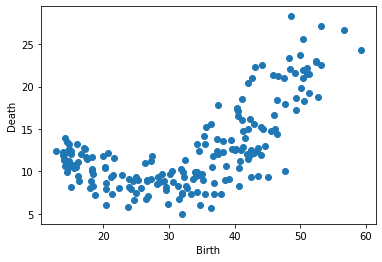

In [17]:
plt.scatter(df["Birth"],df["Death"])
plt.xlabel("Birth")
plt.ylabel("Death")
plt.show()

On peut utiliser un mélange gaussien pour étudier ces données car elles n'ont pas de forme particulière (lineaire, etc). 

Question 6

### Nombre de gaussienne = 2
Alpha estimé :  [0.55040342 0.44959658]
mu estimé:  [[42.14260041 14.98245733]
 [21.88773558  9.78195639]]
Sigma estimé : [[[40.85520263 27.10791214]
  [27.10791214 28.55091826]]

 [[40.74891778 -7.7205492 ]
  [-7.7205492   3.90106936]]]


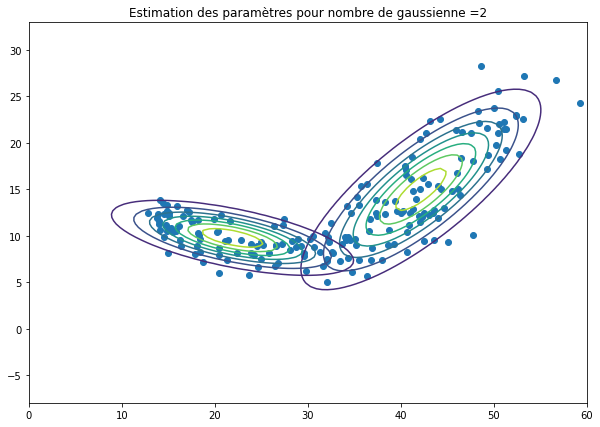

### Nombre de gaussienne = 3
Alpha estimé :  [0.22462836 0.37977397 0.39559767]
mu estimé:  [[16.63541044 11.08835889]
 [31.28749304  9.08792082]
 [44.02736271 16.94199632]]
Sigma estimé : [[[ 5.9381208  -1.727505  ]
  [-1.727505    2.4112679 ]]

 [[45.9462587   4.98195853]
  [ 4.98195853  3.17028655]]

 [[35.8276562  23.33346557]
  [23.33346557 24.67531029]]]


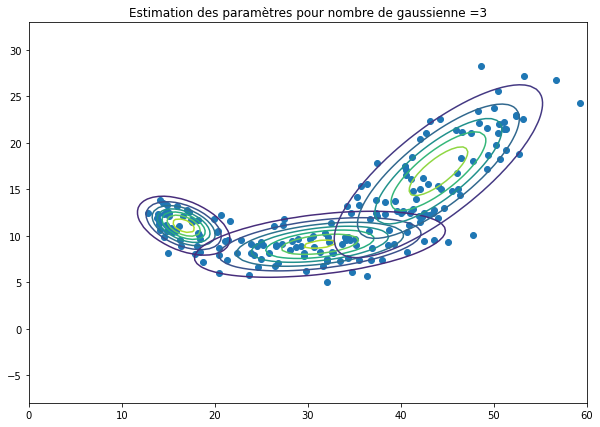

### Nombre de gaussienne = 4
Alpha estimé :  [0.35381106 0.24274756 0.21349024 0.18995114]
mu estimé:  [[44.3910681  17.47763424]
 [25.78304241  8.65697523]
 [37.51836494 10.22093874]
 [16.11707254 11.46094376]]
Sigma estimé : [[[37.80714912 23.80273521]
  [23.80273521 24.12639882]]

 [[24.55417061  0.40949485]
  [ 0.40949485  1.83295961]]

 [[23.92233812  5.7941807 ]
  [ 5.7941807   5.69555548]]

 [[ 4.38816109 -0.8690397 ]
  [-0.8690397   1.68140095]]]


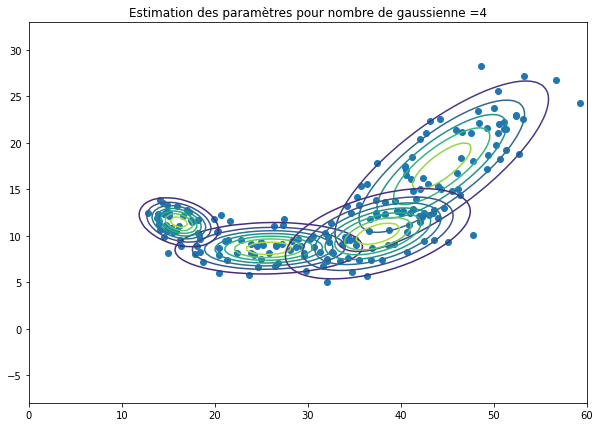

### Nombre de gaussienne = 5
Alpha estimé :  [0.11317509 0.17864847 0.27103607 0.16710792 0.27003243]
mu estimé:  [[14.89623951 11.85541936]
 [49.0273157  21.36361862]
 [30.77679841  8.62435702]
 [19.61771887  9.53131971]
 [40.63084206 13.16783644]]
Sigma estimé : [[[ 1.02493345 -0.14355032]
  [-0.14355032  1.28299027]]

 [[16.2161941   5.48493794]
  [ 5.48493794  8.82889366]]

 [[18.15664858 -0.64496079]
  [-0.64496079  2.15136599]]

 [[ 8.68464799 -2.34360842]
  [-2.34360842  3.35986058]]

 [[11.00910696  0.27281612]
  [ 0.27281612  5.80751929]]]


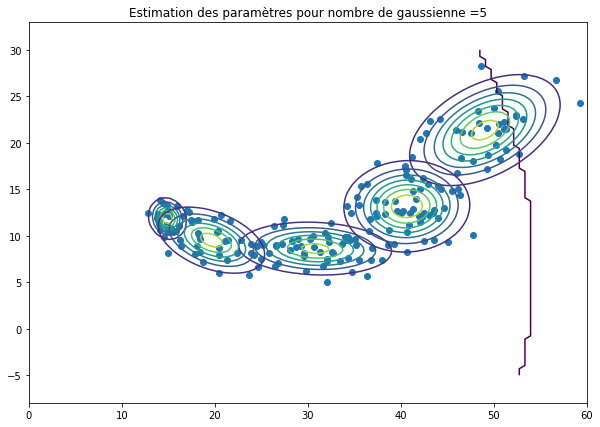

### Nombre de gaussienne = 6
Alpha estimé :  [0.17549252 0.13560798 0.11503506 0.11912632 0.17803676 0.27670135]
mu estimé:  [[32.82900708  8.44751502]
 [18.97489747  9.95057701]
 [25.80019443  8.63586839]
 [14.80183561 11.68969015]
 [49.05107985 21.37452539]
 [40.61266456 13.08648402]]
Sigma estimé : [[[ 7.41143753 -0.30839429]
  [-0.30839429  2.23386267]]

 [[ 4.03073427 -0.94352479]
  [-0.94352479  3.10019653]]

 [[ 4.47952743  1.20069761]
  [ 1.20069761  2.01723624]]

 [[ 0.81357659 -0.26757761]
  [-0.26757761  1.63807339]]

 [[16.08392925  5.42310827]
  [ 5.42310827  8.81074724]]

 [[10.87683643  0.38859893]
  [ 0.38859893  6.13452408]]]


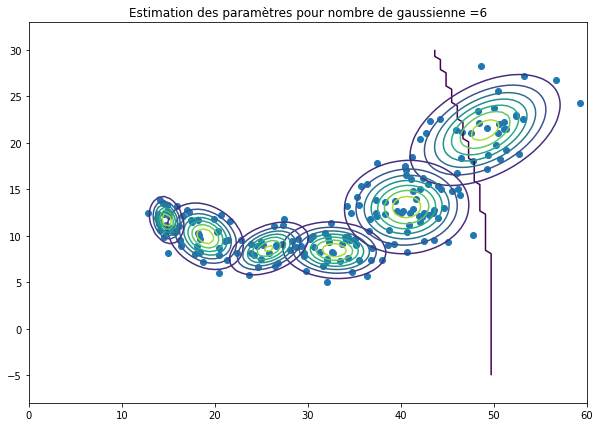

### Nombre de gaussienne = 7
Alpha estimé :  [0.14705821 0.12517489 0.07920405 0.1660965  0.23065592 0.1559651
 0.09584533]
mu estimé:  [[50.25400657 21.31732484]
 [25.87329782  8.65962253]
 [38.91526281 17.22155916]
 [33.17075705  8.37841762]
 [41.3567056  12.79334086]
 [18.44644305 10.19947254]
 [14.59818398 11.77115618]]
Sigma estimé : [[[ 9.80356998  5.09219753]
  [ 5.09219753  7.96012844]]

 [[ 5.55693623  1.35260853]
  [ 1.35260853  2.01141771]]

 [[21.27259726 21.50314095]
  [21.50314095 23.1005796 ]]

 [[ 7.47185851 -0.07890479]
  [-0.07890479  2.16168137]]

 [[ 8.34784577  0.77334118]
  [ 0.77334118  5.10614548]]

 [[ 5.02577266 -1.34727962]
  [-1.34727962  3.13515987]]

 [[ 0.498026   -0.2327072 ]
  [-0.2327072   1.4748663 ]]]


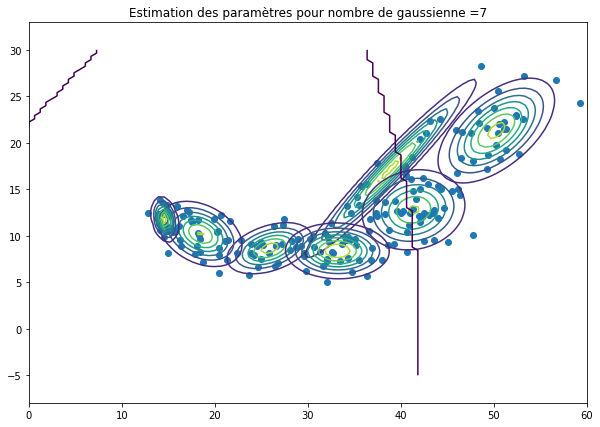

In [42]:
m_list = range(2,8)  ## Chosen at random 

N_max = 30
X = np.array(df)
n = X.shape[0]

mu_est_list = []
sigma_est_list = []
BIC_list = []

for m in m_list:

  #initialisation 
  alpha_0 = np.ones(m)/m
  mu_0 = X[np.random.randint(0,n,m)]
  sigma_0 = np.array([np.eye(2) for i in range(m)]) 

  # calcul des estimateurs et du log vraissemblance
  log_L, alpha_t, mu_t, sigma_t = EM(X, N_max, alpha_0, mu_0, sigma_0)

  mu_est_list.append(mu_t)
  sigma_est_list.append(sigma_t)
  BIC_val = -log_L[-1] + (6*m -1 )*np.log(n)/2
  BIC_list.append(BIC_val)

  # print les estimateurs 
  print("### Nombre de gaussienne =", m)
  print('Alpha estimé : ', alpha_t)
  print('mu estimé: ', mu_t)
  print('Sigma estimé :', sigma_t)
  #plot des résultats
  x = np.linspace(0, 60, num=100)
  y = np.linspace(-5, 30, num=100)
  X_plot, Y_plot = np.meshgrid(x,y)

  p = np.empty(X_plot.shape + (2,))
  p[:, :, 0] = X_plot
  p[:, :, 1] = Y_plot

  plt.figure(figsize=(10,7))
  for j in range(m):
    temp = st.multivariate_normal.pdf(p, mean = mu_t[j], cov = sigma_t[j])
    plt.contour(X_plot, Y_plot, temp)

  plt.scatter(X[:,0],X[:,1])
  plt.axis("equal")

  plt.title("Estimation des paramètres pour nombre de gaussienne ="+ str(m))
  plt.show()
    

In [43]:
best_m_index = np.argmin(BIC_list)
best_m = m_list[best_m_index]
print("Le meilleur nombre de cluster m =", best_m )


Le meilleur nombre de cluster m = 3


### Exercice 3 ###

#### 3-A

Question 1

In [22]:
def f(x):
    if x >= 0:
        return 2*np.sin(np.pi/1.5*x)
    else:
        return 0
    
def p(x):
    if x >= 0:
        return x**0.65*np.exp(-x**2/2)
    else:
        return 0

def q(x,mu = 0.8,sigma = np.sqrt(1.5) ):
    return 2*np.exp(-(mu-x)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

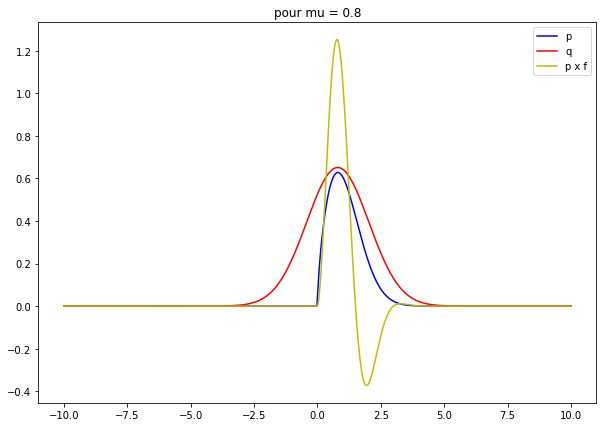

In [23]:
x_list = np.linspace(-10, 10, 500)

val_f = np.array([f(x) for x in x_list])
val_p = np.array([p(x) for x in x_list])
val_q = np.array([q(x) for x in x_list])

val_p_f = val_p*val_f
#val_p_f = val_p_f/ np.linalg.norm(val_p_f)

plt.figure(figsize=(10,7))
plt.plot(x_list, val_p, color ='b', label = 'p')
plt.plot(x_list,val_q , color = 'r', label = 'q')
plt.plot(x_list,val_p_f , color = 'y', label = 'p x f')
plt.title("pour mu = 0.8")
plt.legend()
plt.show()

Question 2

In [24]:
def importance_sampling(N, mu = 0.8,sigma = np.sqrt(1.5)):
  list_x = []

  for i_iter in range(N):
    x = np.random.normal(size=1,loc=mu,scale=sigma**2)
    while x < 0:
      x = np.random.normal(size=1,loc=mu,scale=sigma**2)
    list_x.append(x)


  val_f = np.array([f(x) for x in list_x])
  val_p = np.array([p(x) for x in list_x])
  val_q = np.array([q(x, mu, sigma) for x in list_x])

  w = val_p/val_q

  w = N*w/np.sum(w)
  
  expt = np.sum(w*val_f)/N

  return expt, w

In [25]:
nb_iterations = 50
list_expt = []
list_N = [10,100,1000,10000]

for N in list_N:
  print('## pour N = ', N )
  list_temp = []
  for i in range(nb_iterations):
    expt, w = importance_sampling(N, mu = 0.8,sigma = np.sqrt(1.5))
    list_temp.append(expt)
  list_expt.append(list_temp)

## pour N =  10
## pour N =  100
## pour N =  1000
## pour N =  10000


In [26]:
array_esp_expt = np.array(list_expt).mean(axis = 1)
array_var_expt = np.array(list_expt).var(axis =1)

for i in range(len(list_N)):
  print('## pour N = ', list_N[i] )
  print("Espérance de l'estimateur :", array_esp_expt[i])
  print("Variance de l'estimateur :", array_var_expt[i])
  print('\n')

## pour N =  10
Espérance de l'estimateur : 0.667133479342872
Variance de l'estimateur : 0.16040454202924276


## pour N =  100
Espérance de l'estimateur : 0.7373451688489722
Variance de l'estimateur : 0.020008724885998256


## pour N =  1000
Espérance de l'estimateur : 0.6822075774694725
Variance de l'estimateur : 0.0016991084394750331


## pour N =  10000
Espérance de l'estimateur : 0.6864433950090671
Variance de l'estimateur : 0.00015960190356639262




Plus N augmente, donc plus on échantillone de points, plus la variance de l'estimateur baisse. De plus, à partir de N = 1000, l'espérance de l'estimateur semble converger vers 0.68.

Question 3

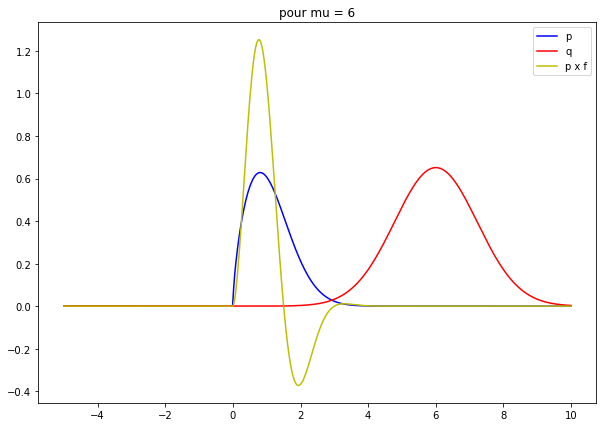

In [28]:
x_list = np.linspace(-5, 10, 500)

val_f = np.array([f(x) for x in x_list])
val_p = np.array([p(x) for x in x_list])
val_q = np.array([q(x, 6) for x in x_list])

val_p_f = val_p*val_f

plt.figure(figsize=(10,7))
plt.plot(x_list, val_p, color ='b', label = 'p')
plt.plot(x_list,val_q , color = 'r', label = 'q')
plt.plot(x_list,val_p_f , color = 'y', label = 'p x f')

plt.title("pour mu = 6")
plt.legend()
plt.show()

## pour N =  10
Estimateur de importance sampling =  -1.8388507869919113 

## pour N =  100
Estimateur de importance sampling =  -1.5161986563100252 

## pour N =  1000
Estimateur de importance sampling =  0.4052864699895416 

## pour N =  10000
Estimateur de importance sampling =  0.9386358304378786 



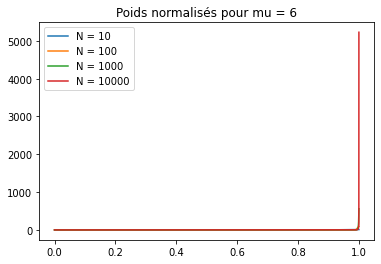

In [29]:
for N in list_N:
  expt, w = importance_sampling(N, mu = 6,sigma = np.sqrt(1.5))
  print('## pour N = ', N )
  print("Estimateur de importance sampling = " , expt ,"\n")
  plt.plot(np.linspace(0,1,len(w)), sorted(w), label = 'N = ' + str(N))

plt.title('Poids normalisés pour mu = 6')
plt.legend()
plt.show()

## pour N =  10
Estimateur de importance sampling =  0.7840938483777502 

## pour N =  100
Estimateur de importance sampling =  0.7749432864742029 

## pour N =  1000
Estimateur de importance sampling =  0.6275205381061655 

## pour N =  10000
Estimateur de importance sampling =  0.6809568103980265 



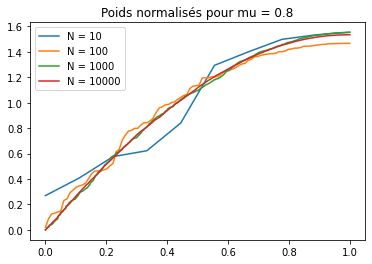

In [30]:
for N in list_N:
  expt, w = importance_sampling(N, mu = 0.8,sigma = np.sqrt(1.5))
  print('## pour N = ', N )
  print("Estimateur de importance sampling = " , expt ,"\n")
  plt.plot(np.linspace(0,1,len(w)), sorted(w), label = 'N = ' + str(N))

plt.title('Poids normalisés pour mu = 0.8')
plt.legend()
plt.show()

Le poids ne sont pas les mêmes dans les cas $\mu = 0.8$ et $\mu = 6$. En effet, en comparant les plot des fonctions $p$ et $q$ pour $\mu = 0.8$ et $\mu = 6$, on voit que:

$\bullet$ pour $\mu = 0.8$ :  $Supp(f x p) \subset Supp(q)$ ie la courbe de $pxf$ et la courbe de $q$ sont superposées autour de 0.8

$\bullet$ pour $\mu = 0.8$ :  $Supp(f x p) \not\subset Supp(q)$ ie la courbe de $pxf$ s'annule presque partout où la courbe $q$ est différente de 0.

Cela explique pourquoi les poids sont si élevés et mauvais pour $\mu = 0.6$, car on n'est pas dans le cadre de la théorie.

#### 3-B

Question 4

Ici, on cherche à calculer : $ \theta^* = arg \max_{\theta}  \int log \left( \sum_{i=1}^M \alpha_i\phi(x| \mu_i, \Sigma_i\right) \nu(x) dx = arg \max_{\theta}\mathbb{E} _{Z \sim \nu} log \left( \sum_{i=1}^M \alpha_i\phi(x| \mu_i, \Sigma_i\right) $ avec $ \theta = (\alpha_i, \mu_i,\Sigma_i)_i$.

Pour cela, on utilise l'algorithme de Monte Carlo de Population (page 6 du TP). En posant : $\hat{B}(\theta,\theta_t) = \mathbb{E} _{Z \sim \nu} log \left( \sum_{j=1}^M \alpha_j\phi(x| \mu_j, \Sigma_j\right) = \sum_{i=1}^n \tilde{w}_i^t log \left( \sum_{j=1}^M \alpha_j\phi(x| \mu_j, \Sigma_j\right)$, on retrouve à l'étape (iii) page l'étape M de l'EM : on calcule $\theta_{t+1} = arg \max_{\theta} \hat{B}(\theta,\theta_t)$.

Alors, avec les mêmes notations que q2.3, on retrouve:


\begin{aligned}
\forall j \in [\![ 1,m ]\!], \alpha^{t+1}_j = \frac{1}{n} \sum_{i=1}^n \tilde{w}_i^t p_{ij}^t
\end{aligned}

\begin{aligned}
 \forall j \in [\![ 1,m ]\!] : \mu^{t+1}_j = \frac{\sum_{i=1}^{n} \tilde{w}_i^t p_{ij}^t x_i}{\sum_{i=1}^{n} \tilde{w}_i^t p_{ij}^t }
\end{aligned}

\begin{aligned}
\forall j \in [\![ 1,m ]\!] :  \Sigma_j^{t+1} = \frac{\sum_{i=1}^{n} \tilde{w}_i^t p_{ij}^t (x_i-\mu_j)(x_i-\mu_j)^T}{\sum_{i=1}^{n}  \tilde{w}_i^t p_{ij}^t}
\end{aligned}

#### 3-C

Question 5

In [31]:
# en reprenant l'algorithme de EM q 3 en rajoutant l'importance sampling


def nu(X, sigma, d, b):
    val_mean = np.zeros(d)

    Sigma = np.eye(d)
    Sigma[0,0] = sigma**2
    
    X_temp = np.copy(X)
    X_temp[:,1] = X[:,1] - b*(X[:,0]**2 - sigma)
    nu = st.multivariate_normal.pdf(X_temp,mean = val_mean,cov=Sigma, allow_singular=True)
    return nu

def q(X, mu, alpha, sigma, n):
    temp_s = np.zeros((n,alpha.size))

    for k in range(alpha.size):
        temp_s[:,k] = st.multivariate_normal.pdf(X,mean = mu[k], cov = sigma[k],allow_singular = True)*alpha[k]
    
    q = np.sum(temp_s,axis = 1)
    return q

def Population_MC(alpha_0, mu_0, sigma_0, n, d, b, sigma_1, N_max):

  m = alpha_0.shape[0]

  alpha_t = alpha_0
  mu_t = mu_0
  sigma_t = sigma_0

  log_L = []
  p_t = np.zeros((n,m))

  for i_iter in range(1,N_max+1):
    if i_iter% 20 == 0:
      print('iter n°',i_iter)

    ### Genérer les X
    Z_t = generate_sequence(n, np.array(range(m)),alpha_t)
    X_t = np.array([st.multivariate_normal.rvs(size=1,mean=mu_t[int(Z_t[i])],cov=sigma_t[int(Z_t[i])]) for i in range(n)])

    ### Calcul des poids de l'importance sampling
    # Calcul de la distribution nu
    nu_dist  = nu(X_t, sigma_1, d, b)

    # Calcul de la distribution q
    q_dist = q(X_t, mu_t, alpha_t, sigma_t, n)

    # Calcul des poids de l'importance sampling
    w = nu_dist/q_dist
    w_tilde = n*w/np.sum(w)

    #print(w_tilde.shape)
    ### Étape E :
    # Calcul de p_t
    p_t = np.array([ st.multivariate_normal.pdf(X_t,mean = mu_t[j], cov = sigma_t[j],allow_singular=True)*alpha_t[j] for j in range(m)]).T
    for i in range(n):
      p_t[i,:] = p_t[i,:] / p_t[i,:].sum()
      
    # ajout poids importance sampling
    for j in range(m):
      p_t[:,j] = p_t[:,j]*w_tilde

    ### Étape M :
    # Calcul des paramètres alpha_t, mu_t, sigma_t
    ## n*alpha_t
    alpha_t = np.sum(p_t,axis = 0)
    
    for j in range(m): 
      ## mu_t    
      temp_mu = np.array([p_t[i,j]*X_t[i] for i in range(n)])
      mu_t[j] = np.sum(temp_mu,axis = 0)/alpha_t[j]
            
      ## sigma_t
      temp_sigma = np.array([p_t[i,j]*np.matmul(np.transpose(np.asmatrix(X_t[i] - mu_t[j])),np.asmatrix(X_t[i] - mu_t[j])) for i in range(n)])
      sigma_t[j] = np.sum(temp_sigma,axis=0)/alpha_t[j]
        
    alpha_t /= n
    
    
    #Calcul du log likehood
    log_L_t = np.array([ st.multivariate_normal.pdf(X,mean = mu_t[j], cov = sigma_t[j], allow_singular=True)*alpha_t[j] for j in range(m)]).T
    log_L.append(np.sum(np.log(log_L_t .sum(axis=1))))

  return log_L, alpha_t, mu_t, sigma_t

Text(0.5, 1.0, 'Nuage de point à partir de $\\nu$')

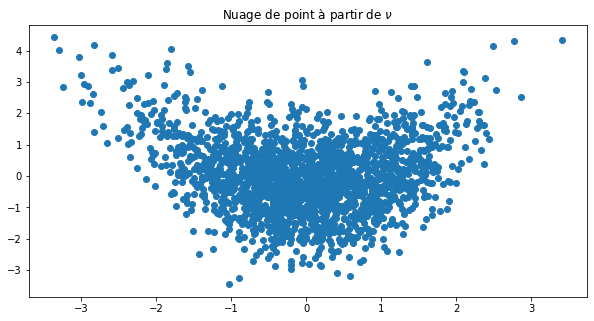

In [32]:
#Initialisation des paramètres

n = 2000
d = 5
b = 0.4
sigma_1 = 1


X = st.multivariate_normal.rvs(size=n,mean=np.zeros(d))
X[:,1] = X[:,1] + b*(X[:,0]**2 - sigma_1)

plt.figure(figsize=(10,5))
plt.scatter(X[:,0],X[:,1])
plt.title("Nuage de point à partir de $\\nu$")

In [37]:
# Test avec 3 gaussiennnes
m = 3

alpha_0 = np.ones(m)/m
mu_0 = 2*(st.uniform.rvs(size=(m,d))-0.5)
sigma_0 = np.array([np.eye(d) for i in range(m)])

N_max = 200

In [38]:
log_L, alpha_t, mu_t, sigma_t = Population_MC(alpha_0, mu_0, sigma_0, n, d, b, sigma_1, N_max)

iter n° 20
iter n° 40
iter n° 60
iter n° 80
iter n° 100
iter n° 120
iter n° 140
iter n° 160
iter n° 180
iter n° 200


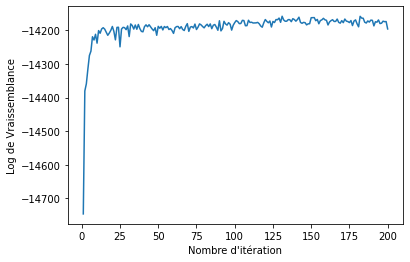

In [39]:
# Affichage des résultats

plt.plot(range(1,N_max+1),log_L)

plt.xlabel("Nombre d'itération")
plt.ylabel("Log de Vraissemblance")

plt.show()

Nombre d'iterations suffisant, le log vraissemblance semble converger vers une valeur stable.

Text(0.5, 1.0, 'Estimation des paramètres pour nombre de gaussienne =3')

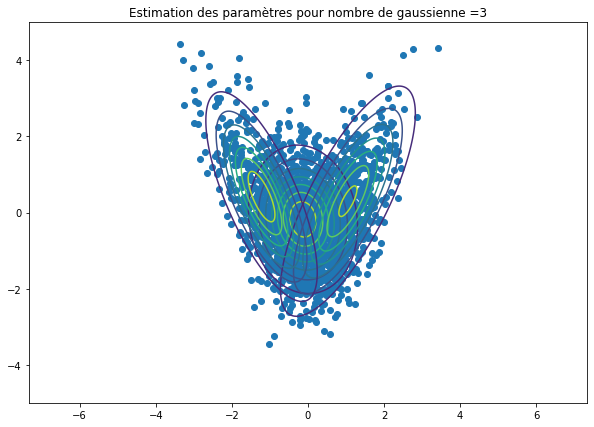

In [40]:

x = np.linspace(-5, 5, num=300)
y = np.linspace(-5, 5, num=300)
X_plot, Y_plot = np.meshgrid(x,y)

p = np.empty(X_plot.shape + (2,))
p[:, :, 0] = X_plot
p[:, :, 1] = Y_plot

plt.figure(figsize=(10,7))
for j in range(m):
    temp = st.multivariate_normal.pdf(p, mean = mu_t[j,:2], cov = sigma_t[j,:2,:2])
    plt.contour(X_plot,Y_plot, temp)
plt.scatter(X[:,0],X[:,1])
plt.axis('equal')
plt.title("Estimation des paramètres pour nombre de gaussienne ="+ str(m))


iter n° 20
iter n° 40
iter n° 60
iter n° 80
iter n° 100


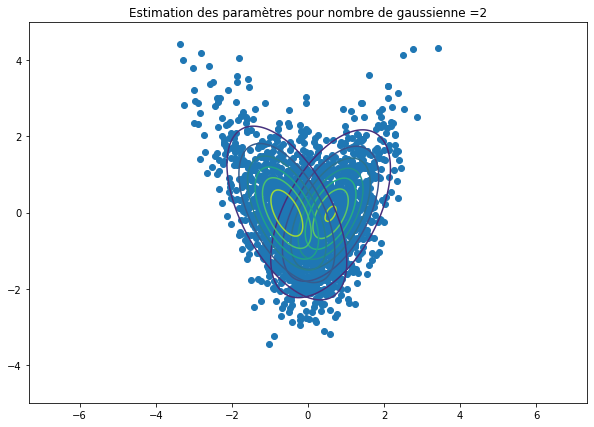

iter n° 20
iter n° 40
iter n° 60
iter n° 80
iter n° 100


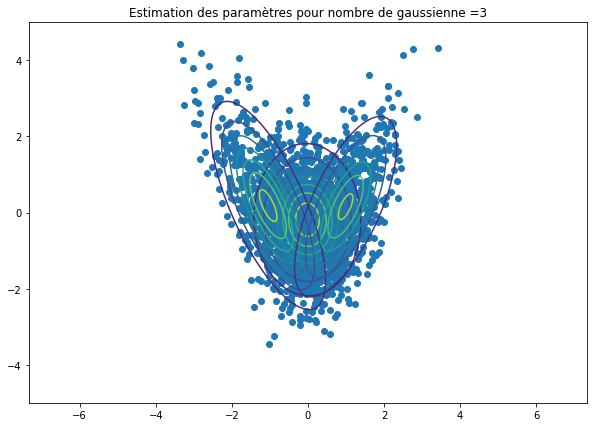

iter n° 20
iter n° 40
iter n° 60
iter n° 80
iter n° 100


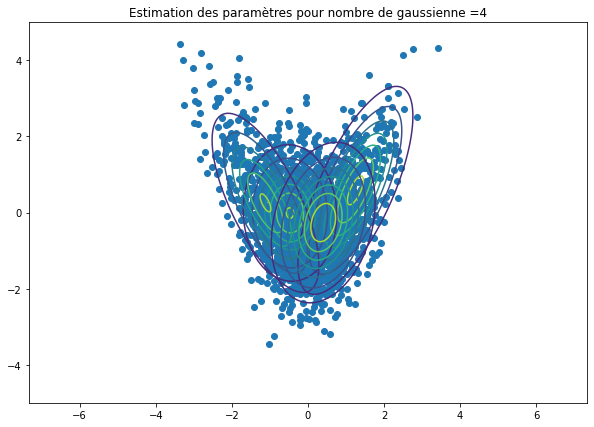

In [41]:
N_max = 100
for m in range(2,5):
  alpha_0 = np.ones(m)/m
  mu_0 = 2*(st.uniform.rvs(size=(m,d))-0.5)
  sigma_0 = np.array([np.eye(d) for i in range(m)])

  log_L, alpha_t, mu_t, sigma_t = Population_MC(alpha_0, mu_0, sigma_0, n, d, b, sigma_1, N_max)

  x = np.linspace(-5, 5, num=300)
  y = np.linspace(-5, 5, num=300)
  X_plot, Y_plot = np.meshgrid(x,y)

  p = np.empty(X_plot.shape + (2,))
  p[:, :, 0] = X_plot
  p[:, :, 1] = Y_plot

  plt.figure(figsize=(10,7))
  for j in range(m):
    temp = st.multivariate_normal.pdf(p, mean = mu_t[j,:2], cov = sigma_t[j,:2,:2])
    plt.contour(X_plot,Y_plot, temp)
  plt.scatter(X[:,0],X[:,1])
  plt.axis('equal')
  plt.title("Estimation des paramètres pour nombre de gaussienne ="+ str(m))
  plt.show()

L'estimation avec m = 3 semble la meilleure.